<table>
  <tr><td>
    <img src="h5.png">
  </td></tr>
<table>

# Project Background

In the beginning of 2021, Indonesia has again stepped up efforts to handle the COVID-19 pandemic. The Government of the Republic of Indonesia through the Instruction of the Ministry of Home Affairs No. 1 of 2021 set a policy to implement Large-Scale Social Restrictions (PSBB) for the islands of Java and Bali. The selection of the area is based on the parameters that have been determined by the Ministry of Health. Through the COVID-19 task force, the government has also created a risk map for each district/city in Indonesia based on the same parameters. This action can be seen as an act of regional grouping based on certain criteria. This project offers grouping of regions using clustering technique. Clustering is the process of grouping data in such a way that data in the same cluster has a high similarity and data in different clusters has a low similarity. This project aims to produce a grouping of provinces based on the dataset used. Important variables for each province such as positive confirmation data, recovered patient data, deceased patients, population, area, number of islands, number of referral hospitals and provincial coordinates.

# Problem Statements

Make a province clusters using clustering method to get cluster have simmilar character member!

# Steps of Clustering using Clustering Method

1. Collecting data using API 
2. Data PreProcessing
3. Clustering Model
4. Model Evaluation
5. Determining Best Models
5. Visualizations
6. Cluster Interpretation
7. Conclusion


# Collecting Data using API

## Package Instalation

Please install the foolowing packages below if they aren't exist in your PC.

In [ ]:
!pip install fuzzy-c-means

In [ ]:
!pip install geopandas

In [ ]:
!pip install descartes

## Import Library

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import requests
import urllib3
from urllib3 import request
import certifi
http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED',ca_certs=certifi.where())

import json
from pandas.io.json import json_normalize

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn import metrics
from fcmeans import FCM
from sklearn.cluster import AgglomerativeClustering

from datetime import datetime

import warnings; warnings.simplefilter('ignore')

## Crawling Data Using API

covid19.go.id provide COVID-19 case data for each province in Indonesia. It collected in different API addres. For example, we can get the COVID-19 data of Special Region of Yogyakarta Province using this addres

https://data.covid19.go.id/public/api/prov_detail_DAERAH_ISTIMEWA_YOGYAKARTA.json.

so, we will create a list consist of province name list for its API below: 

In [2]:
list_provinsi= ['ACEH', 'SUMATERA_UTARA','SUMATERA_BARAT', 'RIAU',
                'JAMBI', 'SUMATERA_SELATAN', 'BENGKULU', 'LAMPUNG',
                'KEPULAUAN_BANGKA_BELITUNG', 'KEPULAUAN_RIAU',
                'DKI_JAKARTA', 'JAWA_BARAT', 'JAWA_TENGAH', 
                'DAERAH_ISTIMEWA_YOGYAKARTA', 'JAWA_TIMUR', 'BANTEN',
                'BALI', 'NUSA_TENGGARA_BARAT', 'NUSA_TENGGARA_TIMUR',
                'KALIMANTAN_BARAT', 'KALIMANTAN_TENGAH', 'KALIMANTAN_SELATAN',
                'KALIMANTAN_TIMUR', 'KALIMANTAN_UTARA', 'SULAWESI_UTARA',
                'SULAWESI_TENGAH', 'SULAWESI_SELATAN', 'SULAWESI_TENGGARA',
                'GORONTALO', 'SULAWESI_BARAT', 'MALUKU', 'MALUKU_UTARA',
                'PAPUA_BARAT', 'PAPUA']

urlawal  = 'https://data.covid19.go.id/public/api/prov_detail_'
urlakhir = '.json'

In [3]:
konfirmasi=[]
sembuh=[]
meninggal=[]
for prov in list_provinsi:
    url=urlawal+prov+urlakhir
    r = http.request('GET', url)
    data = json.loads(r.data.decode('utf-8'))
    dprov = pd.json_normalize(data,'list_perkembangan')
    dprov['tanggal'] = pd.to_datetime(dprov['tanggal']*1e6, unit='ns')
    dprov = dprov.loc[dprov['tanggal']<='2021-01-23']
    konf=dprov.KASUS.sum()
    konfirmasi.append(konf)
    sbh=dprov.SEMBUH.sum()
    sembuh.append(sbh)
    mngl=dprov.MENINGGAL.sum()
    meninggal.append(mngl)

For research interest we add another province data such as population, area, number of island, number referral hospital, and location coordinate. The data have been display below:

In [4]:
data_provinsi=pd.read_csv('https://raw.githubusercontent.com/eliyanto29/My-Academics-Paper-On-Data-Science/master/FCM-Core-and-Reduct/DatasetProvIndo.csv')
data_provinsi.head()

,Provinsi,Jumlah Penduduk Laki-Laki,Jumlah Penduduk Perempuan,Luas,Persentase Terhadap Luas Indonesia,Jumlah Pulau,RS Rujukan,latitude,longitude
0,Aceh,2652616,2636269,57956.00,3.03,663,2,4.415330,96.9956
1,Sumatera Utara,7551087,7481083,72981.23,3.81,419,5,2.363040,99.2161
2,Sumatera Barat,7551087,7481083,42012.89,2.20,391,2,-0.642611,100.6110
3,Riau,2801468,303342,87023.66,4.55,139,3,0.396892,101.7450
4,Jambi,1785699,1712134,50058.16,2.62,19,1,-1.654970,102.8230


We only need tho total population for eac province so we add `Jumlah Penduduk Laki-Laki` and `Jumlah Penduduk Perempuan` and save the result as `Jumlah Penduduk`. 

The we drop the unecessary column, that is `Jumlah Penduduk Laki-Laki`, `Jumlah Penduduk Perempuan` and `Persentase Terhadap Luas Indonesia`. The last column shuld be dropped because its identical with `Luas`. 

In [5]:
data_provinsi['Jumlah Penduduk']=data_provinsi['Jumlah Penduduk Laki-Laki']+data_provinsi['Jumlah Penduduk Perempuan']
data_provinsi.drop(columns=['Jumlah Penduduk Laki-Laki','Jumlah Penduduk Perempuan', 'Persentase Terhadap Luas Indonesia'], inplace=True)
data_provinsi.head()

,Provinsi,Luas,Jumlah Pulau,RS Rujukan,latitude,longitude,Jumlah Penduduk
0,Aceh,57956.00,663,2,4.415330,96.9956,5288885
1,Sumatera Utara,72981.23,419,5,2.363040,99.2161,15032170
2,Sumatera Barat,42012.89,391,2,-0.642611,100.6110,15032170
3,Riau,87023.66,139,3,0.396892,101.7450,3104810
4,Jambi,50058.16,19,1,-1.654970,102.8230,3497833


We need list of Name Provinsi for compund COVID-19 data. So we take it from the `data_provinsi` dataframe

In [6]:
provinsi=[data_provinsi['Provinsi'].values]
provinsi

[array(['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
        'Sumatera Selatan', 'Bengkulu', 'Lampung',
        'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'DKI Jakarta',
        'Jawa Barat', 'Jawa Tengah', 'DI Yogyakarta', 'Jawa Timur',
        'Banten', 'Bali', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
        'Kalimantan Barat', 'Kalimantan Tengah', 'Kalimantan Selatan',
        'Kalimantan Timur', 'Kalimantan Utara', 'Sulawesi Utara',
        'Sulawesi Tengah', 'Sulawesi Selatan', 'Sulawesi Tenggara',
        'Gorontalo', 'Sulawesi Barat', 'Maluku', 'Maluku Utara',
        'Papua Barat', 'Papua'], dtype=object)]

Now, its time to add the the list `konfirmasi`, `sembuh`, and `meninggal` to `data_provinsi` dataframe.

In [7]:
data_provinsi['Konfirmasi']=konfirmasi
data_provinsi['Sembuh']=sembuh
data_provinsi['Meninggal']=meninggal
data_provinsi.head()

,Provinsi,Luas,Jumlah Pulau,RS Rujukan,latitude,longitude,Jumlah Penduduk,Konfirmasi,Sembuh,Meninggal
0,Aceh,57956.00,663,2,4.415330,96.9956,5288885,9126,7605,379
1,Sumatera Utara,72981.23,419,5,2.363040,99.2161,15032170,20133,17392,724
2,Sumatera Barat,42012.89,391,2,-0.642611,100.6110,15032170,26329,23120,585
3,Riau,87023.66,139,3,0.396892,101.7450,3104810,28119,26021,663
4,Jambi,50058.16,19,1,-1.654970,102.8230,3497833,4225,2874,63


We want  to compare the number of Konfirmasi, Sembuh, and Meninggal for each province. So we devide it with Jumlah Penduduk for fairnes.

In [8]:
data_provinsi['Konfirmasi']=konfirmasi/data_provinsi['Jumlah Penduduk']
data_provinsi['Sembuh']=sembuh/data_provinsi['Jumlah Penduduk']
data_provinsi['Meninggal']=meninggal/data_provinsi['Jumlah Penduduk']
data_provinsi.head()

,Provinsi,Luas,Jumlah Pulau,RS Rujukan,latitude,longitude,Jumlah Penduduk,Konfirmasi,Sembuh,Meninggal
0,Aceh,57956.00,663,2,4.415330,96.9956,5288885,0.001726,0.001438,0.000072
1,Sumatera Utara,72981.23,419,5,2.363040,99.2161,15032170,0.001339,0.001157,0.000048
2,Sumatera Barat,42012.89,391,2,-0.642611,100.6110,15032170,0.001752,0.001538,0.000039
3,Riau,87023.66,139,3,0.396892,101.7450,3104810,0.009057,0.008381,0.000214
4,Jambi,50058.16,19,1,-1.654970,102.8230,3497833,0.001208,0.000822,0.000018


`data provinsi` will be our final dataset for clustering process.

# Exploratory Data Anlysis

## Dimensi Data

In [9]:
data_provinsi.shape

(34, 10)

## Variabels

In [10]:
data_provinsi.columns.values 

array(['Provinsi', 'Luas', 'Jumlah Pulau', 'RS Rujukan', 'latitude',
       'longitude', 'Jumlah Penduduk', 'Konfirmasi', 'Sembuh',
       'Meninggal'], dtype=object)

In [11]:
data_provinsi.dtypes

Provinsi            object
Luas               float64
Jumlah Pulau         int64
RS Rujukan           int64
latitude           float64
longitude          float64
Jumlah Penduduk      int64
Konfirmasi         float64
Sembuh             float64
Meninggal          float64
dtype: object

In [12]:
data_provinsi.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Provinsi         34 non-null     object 
 1   Luas             34 non-null     float64
 2   Jumlah Pulau     34 non-null     int64  
 3   RS Rujukan       34 non-null     int64  
 4   latitude         34 non-null     float64
 5   longitude        34 non-null     float64
 6   Jumlah Penduduk  34 non-null     int64  
 7   Konfirmasi       34 non-null     float64
 8   Sembuh           34 non-null     float64
 9   Meninggal        34 non-null     float64
dtypes: float64(6), int64(3), object(1)
memory usage: 2.8+ KB


## Statistics

Then we want to know about the statistics for each variables. We use `.describe()` method for this.

In [13]:
data_provinsi.describe()

,Luas,Jumlah Pulau,RS Rujukan,latitude,longitude,Jumlah Penduduk,Konfirmasi,Sembuh,Meninggal
count,34.000000,34.000000,34.000000,34.000000,34.000000,3.400000e+01,34.000000,34.000000,34.000000
mean,56281.725882,514.823529,3.882353,-3.077311,113.426826,8.631218e+06,0.003910,0.003093,0.000089
std,60990.289464,581.877133,2.771770,3.644531,10.021919,1.145085e+07,0.004028,0.003480,0.000073
min,664.010000,0.000000,1.000000,-8.584430,96.995600,6.636960e+05,0.000686,0.000352,0.000005
25%,17233.465000,131.000000,2.000000,-6.249610,105.336000,2.161306e+06,0.001732,0.001320,0.000045
50%,40378.560000,308.000000,3.000000,-2.982650,112.951000,3.965106e+06,0.002727,0.002098,0.000070
75%,70196.245000,666.750000,4.750000,-0.267632,120.112250,9.147670e+06,0.004543,0.003448,0.000099
max,319036.050000,2408.000000,13.000000,4.415330,138.689000,4.609220e+07,0.022184,0.019722,0.000354


Based on that result, we need a standarization of the data next.

### Check Missing Values

In [14]:
data_provinsi.isnull().sum()

Provinsi           0
Luas               0
Jumlah Pulau       0
RS Rujukan         0
latitude           0
longitude          0
Jumlah Penduduk    0
Konfirmasi         0
Sembuh             0
Meninggal          0
dtype: int64

<AxesSubplot:>

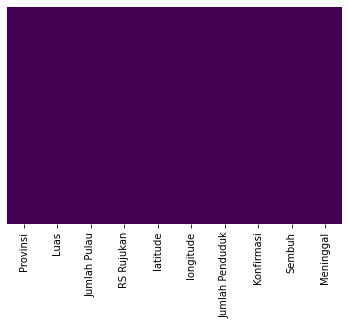

In [15]:
sns.heatmap(data_provinsi.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In this data we don't have missing value

## Check Outlier

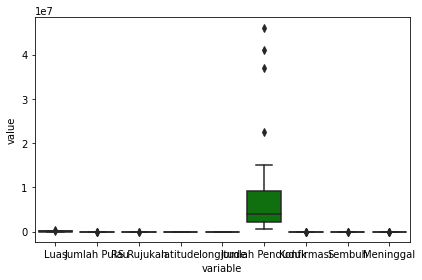

In [16]:
df1=data_provinsi.select_dtypes(include=['float64', 'int64'])#Memilih kolom numerik

sns.boxplot(x="variable", y="value", color='green',orient='v', data=pd.melt(df1))
plt.tight_layout()

Column `Jumlah Penduduk` detected as an outlier. But its make sense based on realty.

## The Corellation of Numeric Data

<AxesSubplot:>

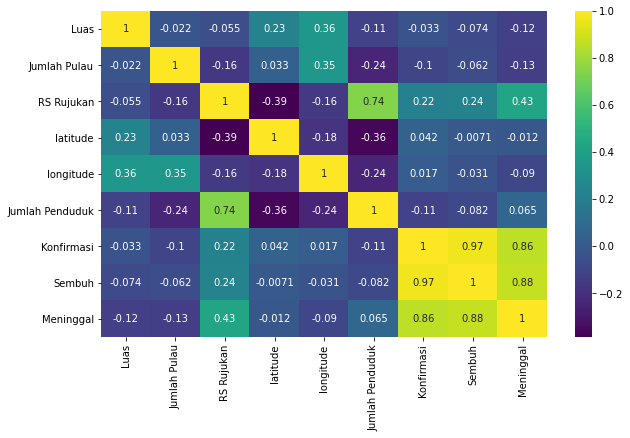

In [17]:
k = len(df1.columns)
cm = df1.corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

## Distribution of Numeric Data

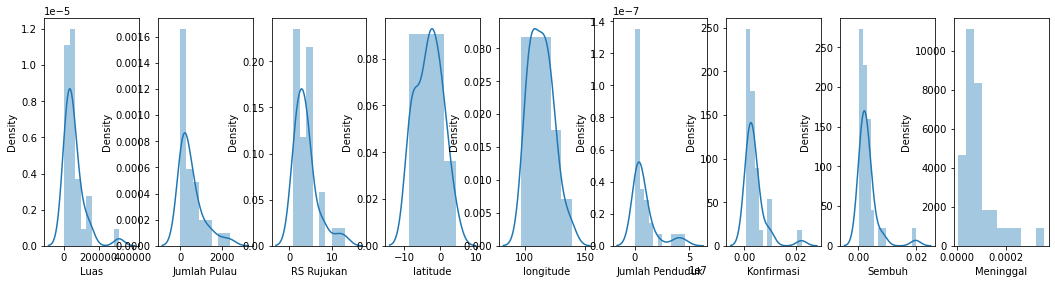

In [18]:
l = df1.columns.values
number_of_columns=len(df1.columns)
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(data_provinsi[l[i]],kde=True) 

### Pairplot

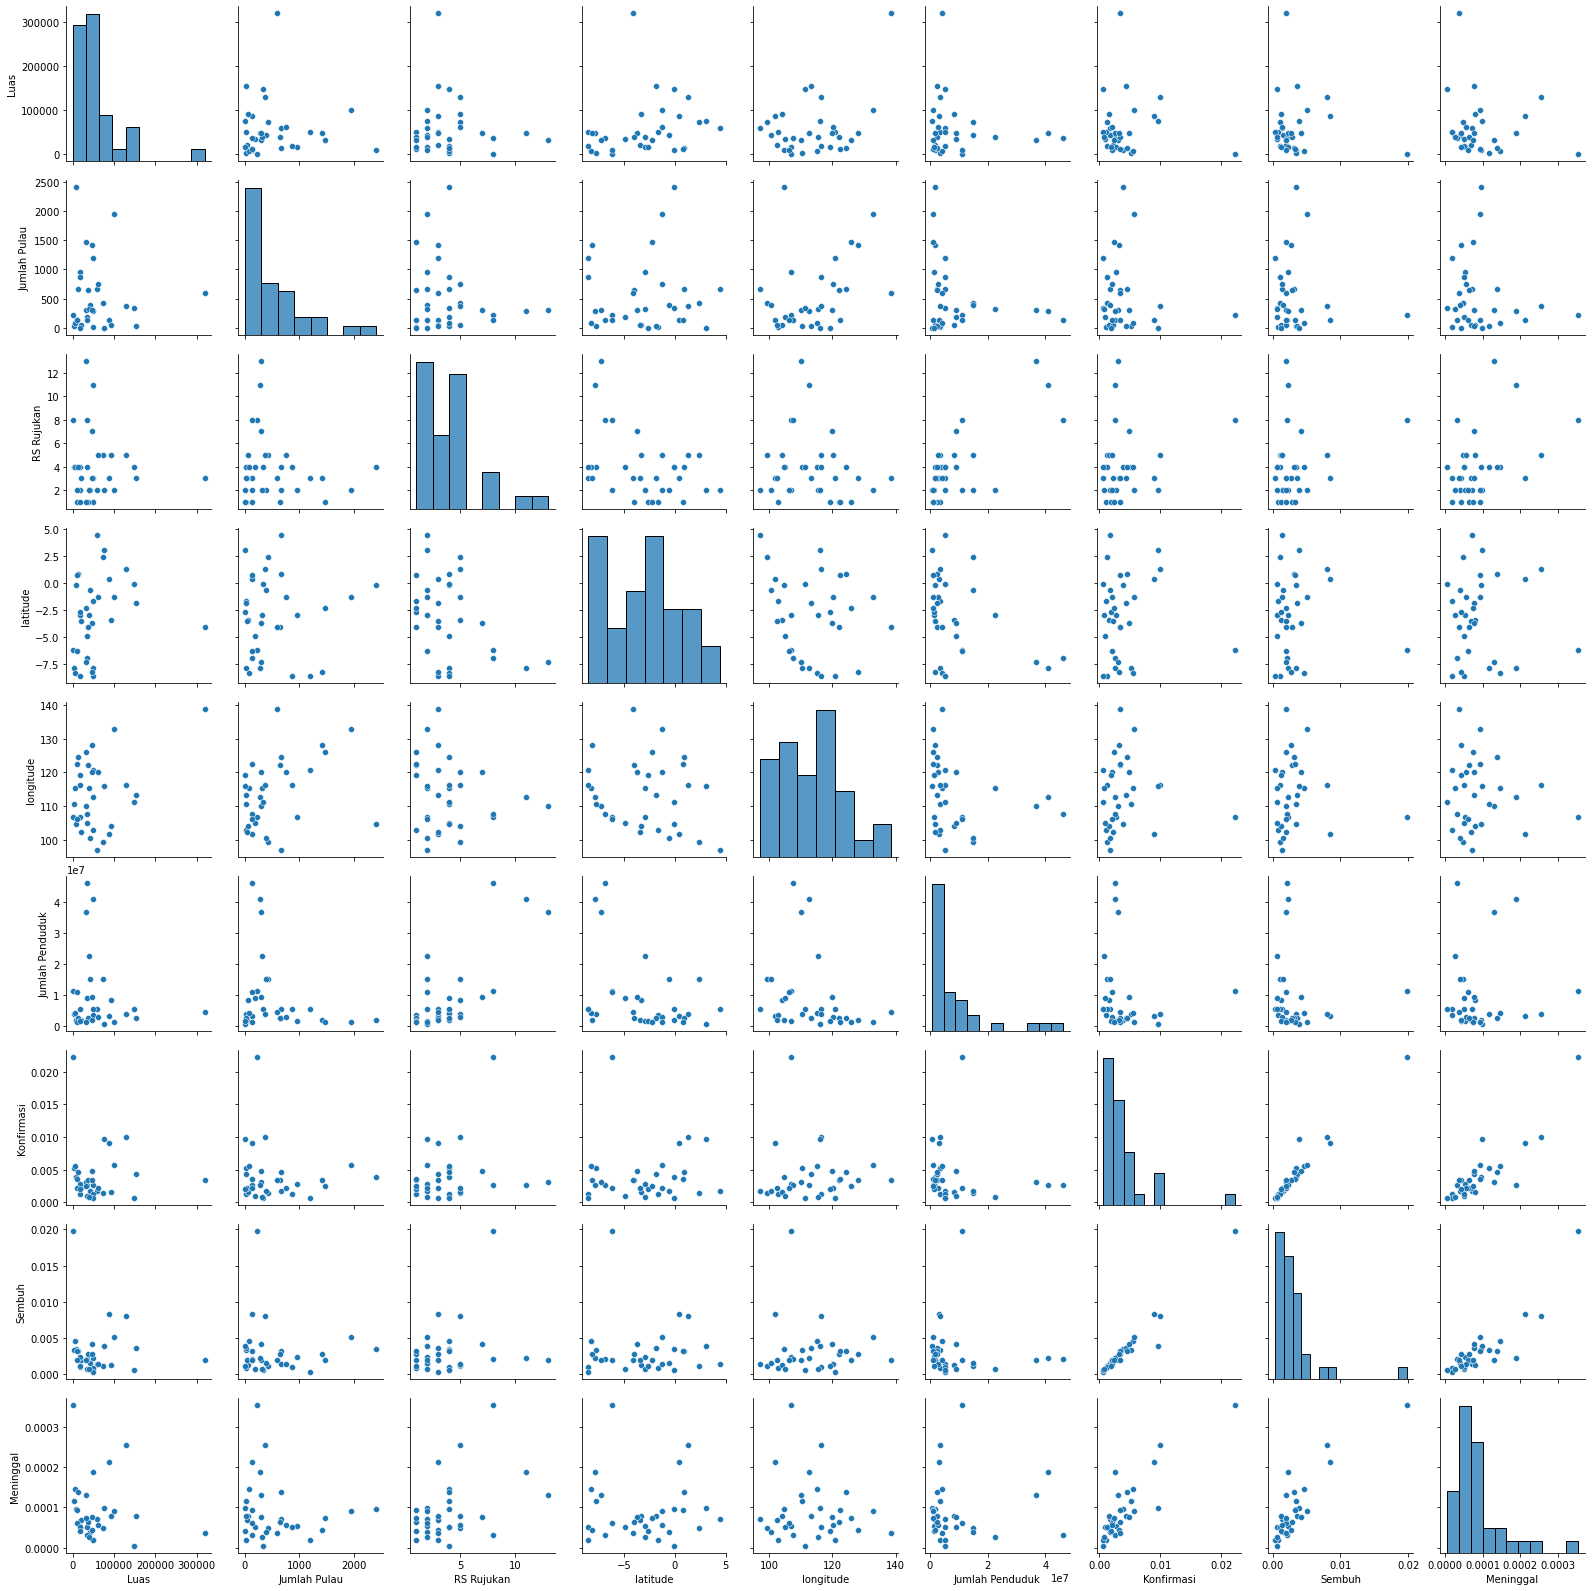

In [19]:
g = sns.pairplot(df1)

# Data Preprocessing

### Data Normalization

We know that the data have very different scale. For 'fairness', we should make its be a same range or scale. So we perform data normalization

Refernce: 
https://neerajkumar.org/writings/svm/#:~:text=SVMs%20assume%20that%20the%20data,the%20SVM%20is%20very%20important.&text=Some%20libraries%20recommend%20doing%20a,dimension%20to%200%20and%201.



In [20]:
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns)

df_norm

,Luas,Jumlah Pulau,RS Rujukan,latitude,longitude,Jumlah Penduduk,Konfirmasi,Sembuh,Meninggal
0,0.179953,0.275332,0.083333,1.000000,0.000000,0.101812,0.048343,0.056084,0.191584
1,0.227147,0.174003,0.333333,0.842129,0.053258,0.316288,0.030379,0.041581,0.124292
2,0.129876,0.162375,0.083333,0.610920,0.086714,0.316288,0.049553,0.061252,0.097810
3,0.271254,0.057724,0.166667,0.690884,0.113913,0.053735,0.389356,0.414515,0.597919
4,0.155146,0.007890,0.000000,0.533045,0.139768,0.062387,0.024266,0.024269,0.037938
5,0.285604,0.022010,0.333333,0.400164,0.169749,0.169022,0.043908,0.049293,0.211567
6,0.060481,0.019518,0.166667,0.392190,0.128855,0.029732,0.070447,0.084929,0.181136
7,0.106667,0.078073,0.250000,0.281961,0.193398,0.184885,0.013857,0.017522,0.135197
8,0.049502,0.394518,0.083333,0.432797,0.235610,0.016353,0.097582,0.101905,0.141099
9,0.023676,1.000000,0.250000,0.649381,0.182413,0.029054,0.151180,0.160338,0.263567


# Modelling

## K-Means Clustering

In [21]:
sns.set(style="ticks", color_codes=True)
random_state = 29

In [22]:
X=np.array(df_norm)

Find the number of cluster recommendation

Text(0.5, 1.0, 'Elbow curve')

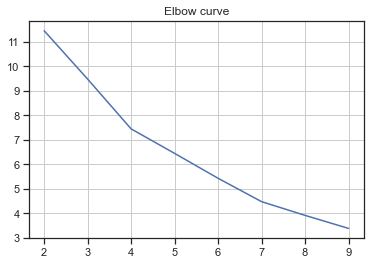

In [23]:
distorsions, k1, kN = [], 2, 10
for k in range(k1, kN):
    kmeans = KMeans(n_clusters=k).fit(X)
    distorsions.append(kmeans.inertia_)
#fig = plt.figure(figsize=(15, 5))
plt.plot(range(k1, kN), distorsions); plt.grid(True)
plt.title('Elbow curve')

Using the Elbow Curve we get the recomendation of number clusters. Based on the plot result above, we see the the 'elbow' located at k=4. So we choose k=4.

<AxesSubplot:ylabel='count'>

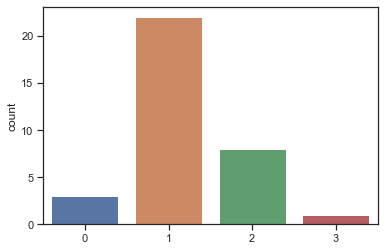

In [55]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
label_kmeans  = kmeans.labels_
sns.countplot(label_kmeans)

In [56]:
label_name=Counter(label_kmeans).keys() 
label_count=Counter(label_kmeans).values() 

print(label_name)
print(label_count)

dict_keys([1, 2, 3, 0])
dict_values([22, 8, 1, 3])


### Fuzzy C-Means Clustering

In [59]:
fcm = FCM(n_clusters=4)
fcm.fit(X)

<AxesSubplot:ylabel='count'>

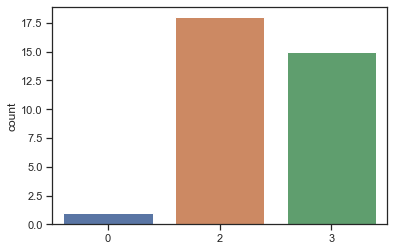

In [60]:
label_fcm = fcm.predict(X)
sns.countplot(label_fcm)

In [61]:
label_name=Counter(label_fcm).keys() 
label_count=Counter(label_fcm).values() 

print(label_name)
print(label_count)

dict_keys([2, 3, 0])
dict_values([18, 15, 1])


### DBSCAN Clustering

In [62]:
dbscan = DBSCAN(eps=0.25, min_samples=2).fit(X)

<AxesSubplot:ylabel='count'>

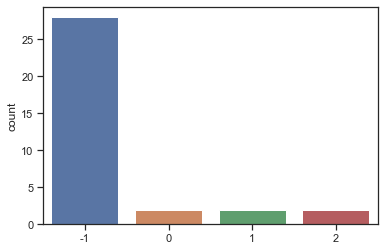

In [63]:
label_dbscan=dbscan.labels_
sns.countplot(label_dbscan)

In [64]:
label_name=Counter(label_dbscan).keys() 
label_count=Counter(label_dbscan).values() 

print(label_name)
print(label_count)

dict_keys([-1, 0, 1, 2])
dict_values([28, 2, 2, 2])


### Hierarchical Clustering

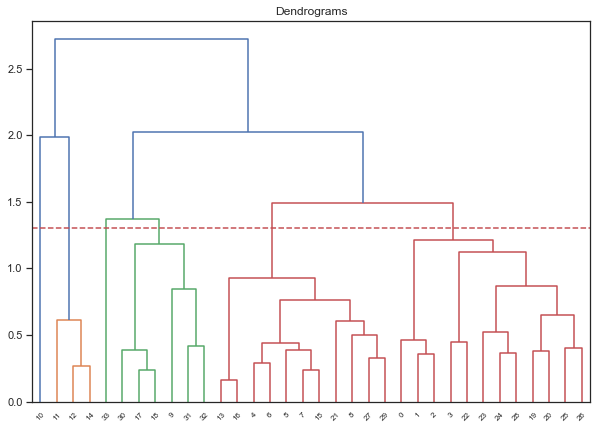

In [108]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_norm, method='ward'))
plt.axhline(y=1.3, color='r', linestyle='--')

<AxesSubplot:ylabel='count'>

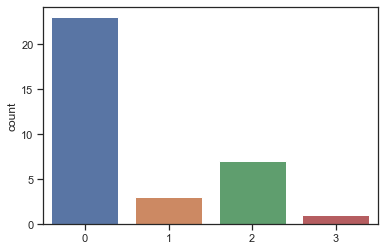

In [68]:
cluster_hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
label_hc = cluster_hc.fit_predict(X)
sns.countplot(label_hc)

In [69]:
label_name=Counter(label_hc).keys() 
label_count=Counter(label_hc).values() 

print(label_name)
print(label_count)

dict_keys([0, 2, 3, 1])
dict_values([23, 7, 1, 3])


# Model Evaluation

In this project we use to metrics for determine the best cluster result, that is Silhouette score and Davies Bouldin Index.
Silhouette Score (SC) is an internal matrix that measures cluster cohesiveness and separation at the same time (Wang et al., 2017). SS values can range from -1 to 1, where 1 means "true" clustering solution and -1 means "false" clustering solution. The Davies-Bouldin index (DBI) is one of the clustering algorithms evaluation measures. It is most commonly used to evaluate the goodness of split by a clustering algorithm for a given number of clusters. In a few words, the score (DBI) is calculated as the average similarity of each cluster with a cluster most similar to it. The lower the average similarity is, the better the clusters are separated and the better is the result of the clustering performed.

In [70]:
DBI_kmeans=metrics.davies_bouldin_score(X, label_kmeans)
DBI_kmeans

1.0361261779063344

In [71]:
SS_kmeans=metrics.silhouette_score(X, label_kmeans, metric='euclidean', sample_size=None, random_state=None)
SS_kmeans

0.26228365668215714

In [72]:
DBI_fcm=metrics.davies_bouldin_score(X, label_fcm)
DBI_fcm

1.628541056686159

In [73]:
SS_fcm=metrics.silhouette_score(X, label_fcm, metric='euclidean', sample_size=None, random_state=None)
SS_fcm

-0.09328349416000617

In [74]:
DBI_dbscan=metrics.davies_bouldin_score(X, label_dbscan)
DBI_dbscan

1.4832949619512472

In [75]:
SS_dbscan=metrics.silhouette_score(X, label_dbscan, metric='euclidean', sample_size=None, random_state=None)
SS_dbscan

-0.1039700881996601

In [76]:
DBI_hc=metrics.davies_bouldin_score(X, label_hc)
DBI_hc

1.0255060269459835

In [42]:
SS_hc=metrics.silhouette_score(X, label_hc, metric='euclidean', sample_size=None, random_state=None)
SS_hc

0.25152202473810964

# Determining The Best Models

In [77]:
dict_evaluation = {'Clustering Method':['K Means', 'FCM', 'DBSCAN', 'Hierarchical'],
                  'Silhouette Score':[SS_kmeans, SS_fcm, SS_dbscan, SS_hc],
                  'DBI':[DBI_kmeans, DBI_fcm, DBI_dbscan, DBI_hc]}

df_evaluation = pd.DataFrame(dict_evaluation)

df_evaluation

,Clustering Method,Silhouette Score,DBI
0,K Means,0.262284,1.036126
1,FCM,-0.093283,1.628541
2,DBSCAN,-0.103970,1.483295
3,Hierarchical,0.251522,1.025506


DBI represent the spreading of clusters, so we put this criteria as main criteria for determining the best cluster. Based on the final table, we chose **Hierarchical** model be the best model. This method also have high Silhouette Score.

# Visualization

In this part of the project we will display the result using geospatial plot. First we need to put the cluster result in the `data_provinsi` dataframe.

In [78]:
data_provinsi['Cluster Label']=label_hc

data_provinsi.head()

,Provinsi,Luas,Jumlah Pulau,RS Rujukan,latitude,longitude,Jumlah Penduduk,Konfirmasi,Sembuh,Meninggal,Cluster Label
0,Aceh,57956.00,663,2,4.415330,96.9956,5288885,0.001726,0.001438,0.000072,0
1,Sumatera Utara,72981.23,419,5,2.363040,99.2161,15032170,0.001339,0.001157,0.000048,0
2,Sumatera Barat,42012.89,391,2,-0.642611,100.6110,15032170,0.001752,0.001538,0.000039,0
3,Riau,87023.66,139,3,0.396892,101.7450,3104810,0.009057,0.008381,0.000214,0
4,Jambi,50058.16,19,1,-1.654970,102.8230,3497833,0.001208,0.000822,0.000018,0


Then, we need to import the geospatial data of Indonesia like folowing syntax below:

In [79]:
# Import GeoJSON Data
path = 'gadm36_IDN_1.json'
df_geo = gpd.read_file(path)
display(df_geo.head())

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,IDN,Indonesia,IDN.1_1,Aceh,,,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((96.66509 2.12018, 96.66765 2.1..."
1,IDN,Indonesia,IDN.2_1,Bali,,,Propinisi,Province,51,ID.BA,"MULTIPOLYGON (((115.59464 -8.81672, 115.59444 ..."
2,IDN,Indonesia,IDN.3_1,Bangka Belitung,,,Propinisi,Province,19,ID.BB,"MULTIPOLYGON (((107.96173 -3.41100, 107.96220 ..."
3,IDN,Indonesia,IDN.4_1,Banten,,,Propinisi,Province,36,ID.BT,"MULTIPOLYGON (((105.54977 -6.99566, 105.55035 ..."
4,IDN,Indonesia,IDN.5_1,Bengkulu,,,Propinisi,Province,17,ID.BE,"MULTIPOLYGON (((102.37586 -5.36968, 102.38067 ..."


For this project we need to modify the Province Name, so we create a list `nama_provinsi` below and change the value of `NAME_1` columns.

In [80]:
nama_provinsi=  ['Aceh', 'Bali', 'Kepulauan Bangka Belitung', 'Banten', 'Bengkulu', 'Gorontalo', 
                 'DKI Jakarta', 'Jambi', 'Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat', 
                 'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur', 'Kepulauan Riau', 
                 'Lampung', 'Maluku', 'Maluku Utara', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 
                 'Papua', 'Papua Barat', 'Riau', 'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah', 
                 'Sulawesi Tenggara', 'Sulawesi Utara', 'Sumatera Barat', 'Sumatera Selatan', 
                 'Sumatera Utara', 'DI Yogyakarta']

In [81]:
df_geo.NAME_1 = nama_provinsi

Then we need to joining two dataframe that is `df_geo` and `data_provinsi` :

In [82]:
df_join = df_geo.merge(data_provinsi, how='inner', left_on="NAME_1", right_on="Provinsi")
df_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33 entries, 0 to 32
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   GID_0            33 non-null     object  
 1   NAME_0           33 non-null     object  
 2   GID_1            33 non-null     object  
 3   NAME_1           33 non-null     object  
 4   VARNAME_1        33 non-null     object  
 5   NL_NAME_1        33 non-null     object  
 6   TYPE_1           33 non-null     object  
 7   ENGTYPE_1        33 non-null     object  
 8   CC_1             33 non-null     object  
 9   HASC_1           33 non-null     object  
 10  geometry         33 non-null     geometry
 11  Provinsi         33 non-null     object  
 12  Luas             33 non-null     float64 
 13  Jumlah Pulau     33 non-null     int64   
 14  RS Rujukan       33 non-null     int64   
 15  latitude         33 non-null     float64 
 16  longitude        33 non-null     float

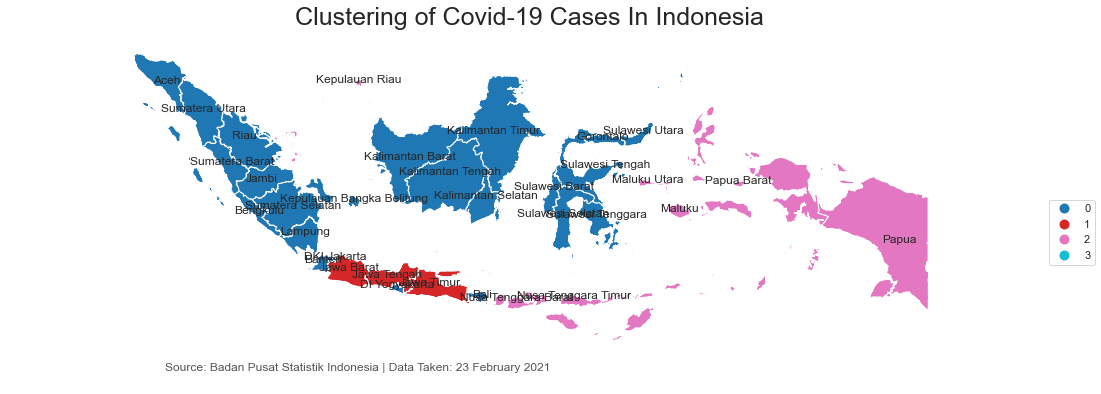

In [83]:
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20, 6))

# add a title
title = 'Clustering of Covid-19 Cases In Indonesia'
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})

df_join.plot(column='Cluster Label', categorical=True, legend=True, ax=ax)

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,0.5))

# remove the axis
ax.set_axis_off()

# create an annotation for the data source
ax.annotate('Source: Badan Pusat Statistik Indonesia | Data Taken: 23 February 2021',xy=(0.15, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12 ,color='#555555')

# Add Labels Province Name
df_join['coords'] = df_join['geometry'].apply(lambda x: x.representative_point().coords[:])
df_join['coords'] = [coords[0] for coords in df_join['coords']]
for idx, row in df_join.iterrows():
    plt.annotate(s=row['Provinsi'], xy=row['coords'],horizontalalignment='center')
    
plt.show()

# Cluster Interpretation

There are three part of clustering process that was critical. They are:
1. Determine Cluster Number
2. Choose the best Cluster
3. Cluster Interpretations

In the final part, that is Cluster Interpretation, we should can interpret the result so we can get the insightful infrmation based on Clustering result. In this project we will perform several step:
1. Check the cluster member of each cluster
2. Check the statistics for each cluster

**Cluster member of each cluster**

In [94]:
cluster1=data_provinsi[data_provinsi['Cluster Label']==0].Provinsi
cluster1

0                          Aceh
1                Sumatera Utara
2                Sumatera Barat
3                          Riau
4                         Jambi
5              Sumatera Selatan
6                      Bengkulu
7                       Lampung
8     Kepulauan Bangka Belitung
13                DI Yogyakarta
15                       Banten
16                         Bali
19             Kalimantan Barat
20            Kalimantan Tengah
21           Kalimantan Selatan
22             Kalimantan Timur
23             Kalimantan Utara
24               Sulawesi Utara
25              Sulawesi Tengah
26             Sulawesi Selatan
27            Sulawesi Tenggara
28                    Gorontalo
29               Sulawesi Barat
Name: Provinsi, dtype: object

In [95]:
cluster2=data_provinsi[data_provinsi['Cluster Label']==1].Provinsi
cluster2

11     Jawa Barat
12    Jawa Tengah
14     Jawa Timur
Name: Provinsi, dtype: object

In [96]:
cluster3=data_provinsi[data_provinsi['Cluster Label']==2].Provinsi
cluster3

9          Kepulauan Riau
17    Nusa Tenggara Barat
18    Nusa Tenggara Timur
30                 Maluku
31           Maluku Utara
32            Papua Barat
33                  Papua
Name: Provinsi, dtype: object

In [97]:
cluster4=data_provinsi[data_provinsi['Cluster Label']==3].Provinsi
cluster4

10    DKI Jakarta
Name: Provinsi, dtype: object

**Statistics for each cluster**

In this part, we want to know, the mean of `Konfirmasi`, `Sembuh`, and `Meninggal` for each cluster we have. So, we will perform `groupby` method below:

In [91]:
konfirmed_cluster = data_provinsi.groupby(data_provinsi['Cluster Label']).agg({'Konfirmasi':np.mean, 
                                                                              'Sembuh':np.mean,
                                                                              'Meninggal':np.mean}).reset_index()
konfirmed_cluster

,Cluster Label,Konfirmasi,Sembuh,Meninggal
0,0,0.003547,0.002715,0.000083
1,1,0.002779,0.002131,0.000117
2,2,0.002977,0.002373,0.000059
3,3,0.022184,0.019722,0.000354


Then we plot it in one figure to display the character for each cluster.

[0 1 2 3]


Text(0.5, 0.98, 'Barplot for Each Cluster')

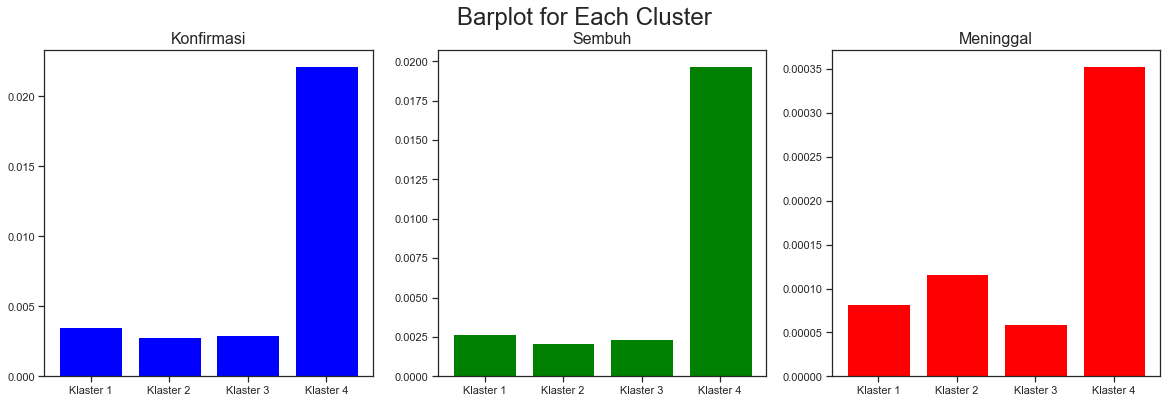

In [93]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

labels = konfirmed_cluster['Cluster Label']
konfirmasi = konfirmed_cluster['Konfirmasi']
sembuh = konfirmed_cluster['Sembuh']
meninggal = konfirmed_cluster['Meninggal']

x = np.arange(len(labels))  # the label locations
print(x)
width = 0.35  # the width of the bars

axs[0].bar(x , konfirmasi, label='Konfirmasi', color='blue')
axs[0].set_title('Konfirmasi', fontsize=16)
axs[1].bar(x , sembuh, label='Sembuh', color='green')
axs[1].set_title('Sembuh', fontsize=16)
axs[2].bar(x , meninggal, label='Meninggal', color='red')
axs[2].set_title('Meninggal', fontsize=16)

for ax in axs.flat:
    ax.set(xticks=x,
           xticklabels=['Klaster 1', 'Klaster 2', 'Klaster 3', 'Klaster 4'])

fig.suptitle('Barplot for Each Cluster', fontsize=24)

Based on picture above, Klaster 4 its significantly different. That is DKI Jakarta.

RI Government by the Instruction of the Ministry of Home Affairs No. 1 of 2021 set a policy to implement Large-Scale Social Restrictions (PSBB) for the islands of Java and Bali. Based on this cluster analysis, acctually only DKI Jakarta that have a significantly  different character. But, the number of Meninggal Cases in Cluster 2 need more attention. So this project hopefully can add the another analysis point of view. We hope this research can help the goverment to take the right policy at the right situation. 

# Conclusion

Based on the cluster analysis that we have done. We get 4 Klaster that is:

Klaster 1:

In [103]:
np.array(cluster1)

array(['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
       'Sumatera Selatan', 'Bengkulu', 'Lampung',
       'Kepulauan Bangka Belitung', 'DI Yogyakarta', 'Banten', 'Bali',
       'Kalimantan Barat', 'Kalimantan Tengah', 'Kalimantan Selatan',
       'Kalimantan Timur', 'Kalimantan Utara', 'Sulawesi Utara',
       'Sulawesi Tengah', 'Sulawesi Selatan', 'Sulawesi Tenggara',
       'Gorontalo', 'Sulawesi Barat'], dtype=object)

Klaster 2:

In [104]:
np.array(cluster2)

array(['Jawa Barat', 'Jawa Tengah', 'Jawa Timur'], dtype=object)

Klaster 3:

In [105]:
np.array(cluster3)

array(['Kepulauan Riau', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Maluku', 'Maluku Utara', 'Papua Barat', 'Papua'], dtype=object)

Klaster 4:

In [107]:
np.array(cluster4)

array(['DKI Jakarta'], dtype=object)

And Based on our anlysis, DKI Jakart only that recomended for PSBB. But The Provinces in Klaster 2 need more attention.